<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Time Series
A time series is a sequence of observations taken at regular time intervals. They can be used for tasks such as anomaly detection and classification but the most common use is forecasting. In this notebook we will use a time series from a [weather station](https://www.bgc-jena.mpg.de/wetter/) in Jena, Germany. The weather data has been collected since 1770 but we will use a smaller dataset collected between 2009 and 2016 every 10 minutes.

The version of Tensorflow used in the examples in the book by Chollet is [version 2.6](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/README.md). Since that is not available in Colab we use version 2.8 replacing the one available by default (2.17)  

In [1]:
!pip install tensorflow==2.8

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 21.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: goog

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-10-26 13:11:49--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.31.225, 16.182.104.200, 52.217.102.110, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.31.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  4.42MB/s    in 2.9s    

2024-10-26 13:11:52 (4.42 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from tensorflow import keras
from keras import layers
from platform import python_version
print('Python version: {}'.format(python_version()))
print('Tensorflow version: {}'.format(tf.__version__))
print('Keras version: {}'.format(keras.__version__))

Python version: 3.10.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [4]:
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()

The dataset contains 420451 records of pressure, air temperature, humidity, and other meteorological variables.

In [9]:
lines = data.split("\n")
header = lines[0].split(",")
record_0 = lines[1].split(",")
lines = lines[1:]
print(header)
print(record_0)
print('Number of records: {:d}'.format(len(lines)))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
['01.01.2009 00:10:00', '996.52', '-8.02', '265.40', '-8.90', '93.30', '3.33', '3.11', '0.22', '1.94', '3.12', '1307.75', '1.03', '1.75', '152.30']
Number of records: 420451


We create two NumPy arrays, one for the temperature values and one for the rest. The temperature values will be used as the target values of the forecasting task while the other parameters will be used as features to learn the function that links the parameters to the temperature

$$T = f(pressure, humidity, wind,..)$$

The model does not use the past values of temperature for the forecasts. This will probably reduce the skill of the model.

In [10]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

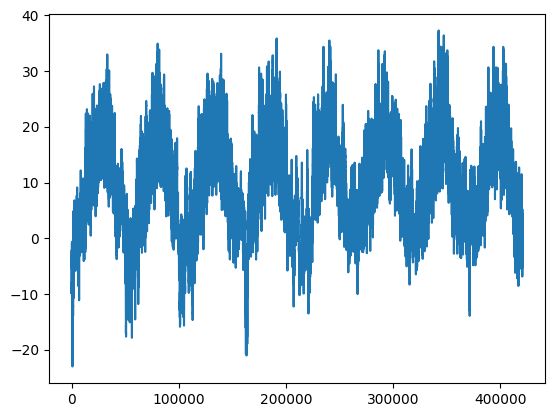

In [11]:
plt.plot(range(len(temperature)), temperature)

We plot a smaller sample of the first 10 days. Since the data is collected every 10 minutes, there are 24 * 6 * 10 = 1440 data points

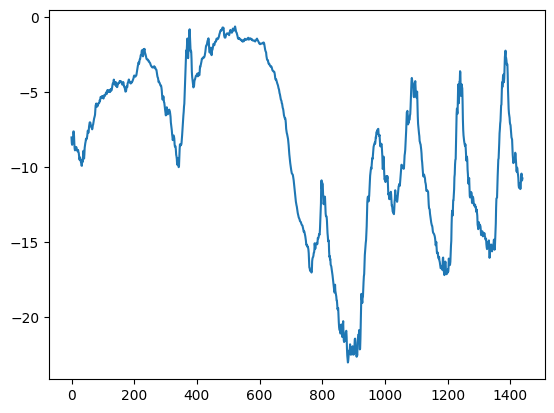

In [12]:
plt.plot(range(1440), temperature[:1440])

## The forecasting task
We want to know wheter we can make a forecast of the temperature for the next 24 hours (lead time) given the records in the previous 5 days sampled every hour. We will use the first 50% of the data for training, the following 25% for validation and the last 25% for testing.    

In [13]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Data preparation
In order to train a model for time series forecasting we have to sample our dataset, the observations. For example we want to use one observation every 6 since we assume the sequence is highly correlated. So we set the sampling rate to 6, that is one sample per hour. Then we have to decide the length of the sequences for the training. For instance we may assume that 5 days of observations is enough to make a forecast for the next 24 hours. Therefore we set the length of the sequences to 5 x 24 = 120 observations. Finally we set the delay to extract the target sequence to be the same as the lead time we want our model to be able to forecast. So for each sequence extracted from the time series we can extract the target sequence just using a delay of the same length as the lead time. One last value we have to set is the number of sequences in the batch. In this example we set the number of sequences in the batch to 256.

Since the range of values of the variables is different we normalize the data by subtracting the mean and dividing by the standard deviation

In [15]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [16]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256
delay

858

We use a utility function from keras to create the training and validation set and the test set.

In [17]:
train_dataset = keras.utils.timeseries_dataset_from_array(
                                                        raw_data[:-delay],
                                                        targets=temperature[delay:],
                                                        sampling_rate=sampling_rate,
                                                        sequence_length=sequence_length,
                                                        shuffle=True,
                                                        batch_size=batch_size,
                                                        start_index=0,
                                                        end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
                                                        raw_data[:-delay],
                                                        targets=temperature[delay:],
                                                        sampling_rate=sampling_rate,
                                                        sequence_length=sequence_length,
                                                        shuffle=True,
                                                        batch_size=batch_size,
                                                        start_index=num_train_samples,
                                                        end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
                                                        raw_data[:-delay],
                                                        targets=temperature[delay:],
                                                        sampling_rate=sampling_rate,
                                                        sequence_length=sequence_length,
                                                        shuffle=True,
                                                        batch_size=batch_size,
                                                        start_index=num_train_samples + num_val_samples)

Our datasets are tuples (samples, targets) of input sequences. Each tuple contains 120 data points and a target delayed temperature value. As said, the inputs are variables such as pressure, wind speed, humidity, and other meteorological variables. The sequences in each dataset are shuffled, that is their position in the dataset is random but the observations in each sequence are kept in the same order.

In [18]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


So in the train dataset we have a batch of 256 sample sequences of lenght 120 for each of the 14 variables that will be used to infer the temperature. The target of each sample sequence in the batch is one temperature value.

## The baseline
Before building our forecasting model we may want to build a simpler common-sense model, a baseline, to compare its skill against it. We assume our baseline model to always forecast the last temperature values for the next 24 hours. We can compute the mean absolute error (MAE) as the absolute difference between such predictions and the observations. For the predictions we take the temperature value, i.e. column 1, of the last observation, i.e. the set of variables such as pressure, temperature, etc, of each sample sequence.

In [19]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        # Check if the batch size is 0
        if samples.shape[0] == 0:
            print("Warning: Batch size is 0. Skipping this batch.")
            continue  # Skip this batch and move to the next one
        preds = samples[:, -1, 1] * std[1] + mean[1] # inversion of the normalized temperature value from the last observation of a sequence in the batch
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [21]:
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 10.28
Test MAE: 10.40


## A simple shallow neural network model
Before building a deep neural network we build another simple model based of a shallow fully connected neural network. Since this model does not have memory we have to provide the network complete, as far as we know, examples of sequences, that is, each sequence is a data point. The input is a sequence of 120 observations of 14 variables. The hidden layer has 16 units. Each one of 120 x 14 = 1680 units of the input layer is connected to each of the 16 units of the hidden layer for a total of 1680 x 16 = 26880 weights to which we have to add the 16 weights for the connections of the units of the hidden layer to the single unit of the output layer for a total number of 26896 weights. We flatten the input data to compute the weights in the fully connected layer but this operation destroys the time order.

In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [23]:
callbacks = [
             keras.callbacks.ModelCheckpoint("jena_dense.keras",
             save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [24]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 49s 59ms/step - loss: 12.6312 - mae: 2.7603 - val_loss: 12.8101 - val_mae: 2.8343
Epoch 2/10
819/819 [==============================] - 45s 54ms/step - loss: 9.2049 - mae: 2.3887 - val_loss: 12.5923 - val_mae: 2.7962
Epoch 3/10
819/819 [==============================] - 45s 54ms/step - loss: 8.3628 - mae: 2.2798 - val_loss: 12.1648 - val_mae: 2.7695
Epoch 4/10
819/819 [==============================] - 45s 54ms/step - loss: 7.8821 - mae: 2.2160 - val_loss: 10.6914 - val_mae: 2.5813
Epoch 5/10
819/819 [==============================] - 44s 54ms/step - loss: 7.4808 - mae: 2.1611 - val_loss: 10.5341 - val_mae: 2.5585
Epoch 6/10
819/819 [==============================] - 44s 53ms/step - loss: 7.2590 - mae: 2.1282 - val_loss: 11.4812 - val_mae: 2.6764
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 7.0650 - mae: 2.1010 - val_loss: 12.3680 - val_mae: 2.7669
Epoch 8/10
819/819 [==============================] - 

We assess the performance of the shallow neural network model on the test set. We achieve a MAE of 2.70, similar to that achieved by the common-sense baseline model.

In [25]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 15s 35ms/step - loss: 11.4055 - mae: 2.6605
Test MAE: 2.66


In [26]:
def plot_mae(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training MAE")
    plt.plot(epochs, val_loss, "b", label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

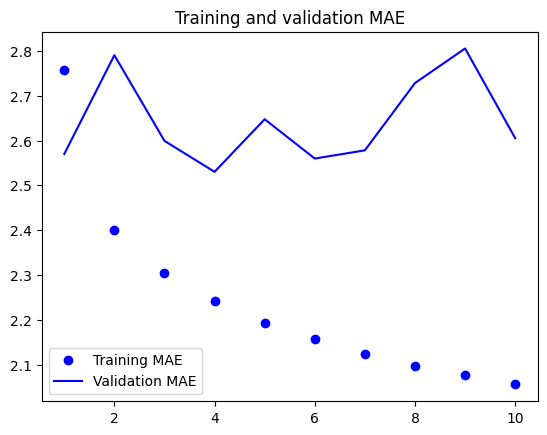

In [ ]:
plot_mae(history)

## A 1D convolutional model
The shallow neural network did not achieve a better result than the common-sense baseline so we try another model slightly more complex than the shallow model: a one dimensional convolution. It works like the 2D convolution but only in one dimension. As for a 2D filter learnt by a convolution model the output of a 1D filter should not depend on the location on the sequence and be able to extract a pattern wherever it is. We start with a kernel (window) of 24 datapoints for the first layer and then we halve the window. The last layer contains only one unit and outputs a real value for the temperature. We use MaxPooling in the model to reduce the size of the feature maps but this operation destroys the time order information.  

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x) # max pooling destroys the time information
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 8)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

In [28]:
callbacks = [
   keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 80s 97ms/step - loss: 23.6354 - mae: 3.7772 - val_loss: 17.3024 - val_mae: 3.3213
Epoch 2/10
819/819 [==============================] - 79s 96ms/step - loss: 15.6116 - mae: 3.1493 - val_loss: 17.2355 - val_mae: 3.2678
Epoch 3/10
819/819 [==============================] - 78s 95ms/step - loss: 14.5212 - mae: 3.0359 - val_loss: 15.2365 - val_mae: 3.0691
Epoch 4/10
819/819 [==============================] - 79s 96ms/step - loss: 13.6991 - mae: 2.9468 - val_loss: 14.6319 - val_mae: 3.0290
Epoch 5/10
819/819 [==============================] - 82s 100ms/step - loss: 13.0474 - mae: 2.8720 - val_loss: 16.4798 - val_mae: 3.2070
Epoch 6/10
819/819 [==============================] - 79s 96ms/step - loss: 12.5547 - mae: 2.8133 - val_loss: 15.3667 - val_mae: 3.1000
Epoch 7/10
819/819 [==============================] - 78s 95ms/step - loss: 12.1823 - mae: 2.7668 - val_loss: 15.1855 - val_mae: 3.0746
Epoch 8/10
819/819 [===========================

The performance of the 1D convolution model  on the test set with a MAE of 3.11 is even worse than the shallow model.

In [29]:
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 18s 43ms/step - loss: 16.6123 - mae: 3.2484
Test MAE: 3.25


## A simple LSTM-based model
We have seen two machine learning models that do not do better than the common-sense baseline model. That does not mean that a machine learning approach, and in particular those based on neural networks, cannot be used to deal with time series. The recurrent neural networks is a family of models specifically built to deal with time series.

In [30]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [31]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [32]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 98s 118ms/step - loss: 45.3728 - mae: 4.9047 - val_loss: 13.4198 - val_mae: 2.7891
Epoch 2/10
819/819 [==============================] - 102s 124ms/step - loss: 11.2873 - mae: 2.6037 - val_loss: 9.8907 - val_mae: 2.4488
Epoch 3/10
819/819 [==============================] - 98s 120ms/step - loss: 9.9239 - mae: 2.4497 - val_loss: 9.6058 - val_mae: 2.4094
Epoch 4/10
819/819 [==============================] - 100s 121ms/step - loss: 9.4289 - mae: 2.3847 - val_loss: 9.7754 - val_mae: 2.4412
Epoch 5/10
819/819 [==============================] - 111s 135ms/step - loss: 9.1109 - mae: 2.3430 - val_loss: 9.8172 - val_mae: 2.4524
Epoch 6/10
819/819 [==============================] - 107s 130ms/step - loss: 8.8788 - mae: 2.3117 - val_loss: 9.9999 - val_mae: 2.4692
Epoch 7/10
819/819 [==============================] - 116s 141ms/step - loss: 8.6538 - mae: 2.2830 - val_loss: 9.9767 - val_mae: 2.4691
Epoch 8/10
819/819 [===========================

This time the model's performance is better than the baseline. It achieves a MAE of 2.60 against the 2.62 of the baseline, a little improvement but still an improvement. The reason why a recurrent model achieves a better result than the fully connected and convolutional model is that these two models do not have memory. No information is kept about the state of the system being modeled after an input sequence has been processed. So the reasons why the fully connected and the convolutional model do not work when dealing with time series is twofold. The first reason is that they process a sequence of data points as one single array of values without paying attention to the temporal order, and the second reason is that they do not have memory.

In [33]:
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 24s 57ms/step - loss: 11.2326 - mae: 2.6242
Test MAE: 2.62


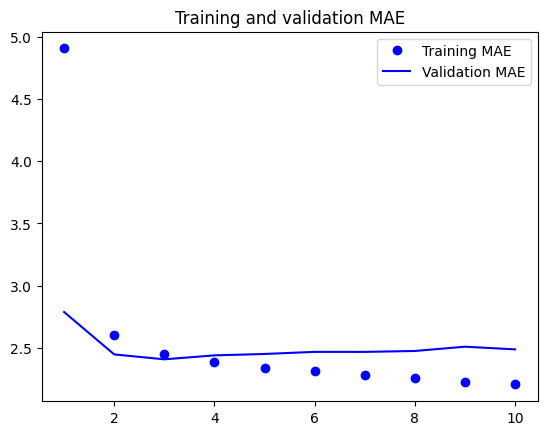

In [34]:
plot_mae(history)

## Recurrent neural networks
The LSTM model that achieved a result better than the baseline is part of the recurrent neural network family of models. These models are based on a recurrent connection that keeps the information about the state of the network simply by adding the output of the previous input to the next input to produce the output.

![recurrent connection](https://github.com/luigiselmi/dl_tensorflow/blob/main/images/recurrent_connection.jpg?raw=1)

Each sequence in a batch is processed recursively and not as one single data point. We can specify the length of a sequence or we can just process any sequence independently of its length. Like in any neural network seen so far, the output will depend on some weights that will be optimized in order to minimize the loss. There are several ways to implement such recurrence and that is the reason why there exist many recurrent networks. An LSTM recurrent network can manage long sequences avoiding the *vanishing gradient* problem during training.

### Recurrent dropout to fight overfitting
If we look at the loss and validation plot of our LSTM model we can see that the validation and the training loss diverge just after few epoch. This is a sign of overfitting. Keras implements a dropout layer that is specific for recurrent networks but the idea is the same as for the fully connected layers: reducing the number of parameters. In order to train the next model it is recommended to switch to a GPU runtime.

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                6016      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [37]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

The LSTM layer with dropout takes a long time to run 50 epochs, even on a GPU runtime, so we do not run the model. The MAE on the test data should achieve a value close to 2.45 °C, so below the baseline.

In [39]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 206s 249ms/step - loss: 28.0439 - mae: 3.8999 - val_loss: 9.6677 - val_mae: 2.4070
Epoch 2/50
819/819 [==============================] - 198s 241ms/step - loss: 14.6507 - mae: 2.9684 - val_loss: 9.3512 - val_mae: 2.3772
Epoch 3/50
819/819 [==============================] - 199s 243ms/step - loss: 13.7628 - mae: 2.8747 - val_loss: 9.1459 - val_mae: 2.3512
Epoch 4/50
819/819 [==============================] - 202s 245ms/step - loss: 13.0797 - mae: 2.8065 - val_loss: 9.0915 - val_mae: 2.3407
Epoch 5/50
819/819 [==============================] - 198s 242ms/step - loss: 12.5847 - mae: 2.7523 - val_loss: 8.9675 - val_mae: 2.3308
Epoch 6/50
819/819 [==============================] - 200s 244ms/step - loss: 12.2907 - mae: 2.7204 - val_loss: 9.3654 - val_mae: 2.3896
Epoch 7/50
819/819 [==============================] - 194s 237ms/step - loss: 11.9370 - mae: 2.6809 - val_loss: 9.0504 - val_mae: 2.3276
Epoch 8/50
819/819 [=====================

In [40]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 30s 72ms/step - loss: 10.1724 - mae: 2.5171
Test MAE: 2.52


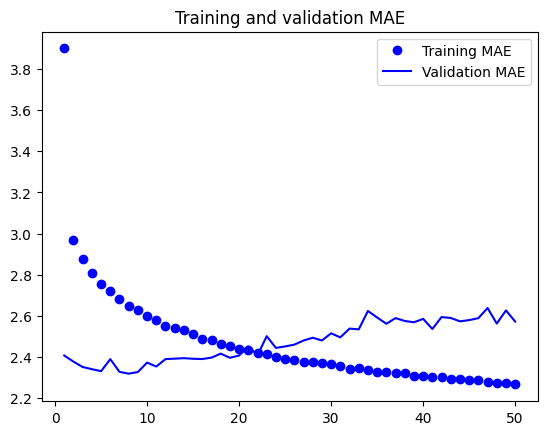

In [41]:
plot_mae(history)

## Stacking recurrent layers
When there is no overfitting we can try to achieve a better result, that is a lower error, by increasing the capacity of the network. We can do that by adding more units to each layer or by adding more layers. We will use a GRU recurrent layer, a slightly simplified version of a LSTM.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

We can choose among several options to save the weights during training. This may be useful for long training time in order to not loose the data in Colab in case a session is stopped.

In [ ]:
#callbacks = keras.callbacks.ModelCheckpoint(filepath="jena_stacked_gru_dropout.keras",
#                                                 save_weights_only=True,
#                                                 verbose=1)

# Create a callback that saves the model's weights every 5 epochs
callbacks = keras.callbacks.ModelCheckpoint(
    filepath="jena_stacked_gru_dropout.keras",
    verbose=1,
    save_weights_only=True,
    save_freq=1)


#callbacks = [
#    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras", save_best_only=True)
#]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [ ]:
history = model.fit(train_dataset,
                    epochs=35, #50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/35

Epoch 1: saving model to jena_stacked_gru_dropout.keras
  1/819 [..............................] - ETA: 1:05:24 - loss: 13.0128 - mae: 2.8713
Epoch 1: saving model to jena_stacked_gru_dropout.keras
  2/819 [..............................] - ETA: 8:00 - loss: 13.3855 - mae: 2.8784   
Epoch 1: saving model to jena_stacked_gru_dropout.keras
  3/819 [..............................] - ETA: 8:38 - loss: 13.5439 - mae: 2.8760
Epoch 1: saving model to jena_stacked_gru_dropout.keras
  4/819 [..............................] - ETA: 11:04 - loss: 13.2286 - mae: 2.8363
Epoch 1: saving model to jena_stacked_gru_dropout.keras
  5/819 [..............................] - ETA: 12:29 - loss: 13.2931 - mae: 2.8321
Epoch 1: saving model to jena_stacked_gru_dropout.keras
  6/819 [..............................] - ETA: 12:41 - loss: 13.5093 - mae: 2.8453
Epoch 1: saving model to jena_stacked_gru_dropout.keras
  7/819 [..............................] - ETA: 11:54 - loss: 13.5322 - mae: 2.8570
Epoch

In [ ]:
model.load_weights("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 41s 100ms/step - loss: 9.9885 - mae: 2.4678
Test MAE: 2.47


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 gru (GRU)                   (None, 120, 32)           4608      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10977 (42.88 KB)
Trainable params: 10977 (42.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Bidirectional RNNs
We can use two recurrent layers to process the data in two direction instead of the same one. This technique allows the extraction of patterns that may be overlooked when looking only in one direction. This technique can be used in natural language processing (NLP) where the order of words in a sentence is not relevant. The technique cannot be used when it is known that the latest data provide better information to forecast the future, as in the case of the temperature.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)